# Gradient Boosting regressor 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Import photoz data + filter out bad objects

These are some of the criteria from Schuldt et al. 2020
* source type is GALAXY or LRG 
* z>0
* z != 9.99992
* 0<zerr <1
* the galaxy identification number (ID) is unique
* specz flag homogeneous is False

In [2]:
photozdata = pd.read_csv('/data/HSC/HSC_IMAGES_FIXED/HSC_photozdata_full_header_trimmed.csv')
filt = (photozdata['specz_redshift'] < 4) & (photozdata['specz_redshift'] > 0)& (photozdata['specz_redshift_err'] > 0) \
       & (photozdata['specz_redshift_err'] < 1)
photozdata_subset = photozdata[filt]

In [3]:
#photozdata


In [4]:
#photozdata.info()

In [5]:
check_nan =photozdata.isnull().values.any()
check_nan

True

In [6]:
photozdata.isna().sum().sum()

1810

In [5]:
#photozdata.describe()

In [6]:
X = photozdata_subset[['g_cmodel_mag','r_cmodel_mag','i_cmodel_mag','z_cmodel_mag','y_cmodel_mag']]
y = photozdata_subset['specz_redshift']


In [9]:
# Use plotly + cufflinks for interactive plotting
import cufflinks as cf

In [10]:
#pip install cufflinks


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Accuracy: 0.915 (0.028)


GradientBoostingClassifier()

In [7]:
# histogram-based gradient boosting for regression in scikit-learn
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from matplotlib import pyplot
# define dataset
X, y = make_regression(n_samples=1000, n_features=10, n_informative=5, random_state=1)
# evaluate the model
model = HistGradientBoostingRegressor()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset
model = HistGradientBoostingRegressor()
model.fit(X, y)
# make a single prediction
#row = [[2.02220122, 0.31563495, 0.82797464, -0.30620401, 0.16003707, -1.44411381, 0.87616892, -0.50446586, 0.23009474, 0.76201118]]
#yhat = model.predict(row)
#print('Prediction: %.3f' % yhat[0])


MAE: -12.723 (1.540)


HistGradientBoostingRegressor()

In [12]:
from sklearn.ensemble import GradientBoostingRegressor
# Set lower and upper quantile
LOWER_ALPHA = 0.1
UPPER_ALPHA = 0.9
# Each model has to be separate
lower_model = GradientBoostingRegressor(loss="quantile",                   
                                        alpha=LOWER_ALPHA)
# The mid model will use the default loss
mid_model = GradientBoostingRegressor(loss="ls")
upper_model = GradientBoostingRegressor(loss="quantile",
                                        alpha=UPPER_ALPHA)

In [13]:
# Fit models
lower_model.fit(X_train, y_train)
mid_model.fit(X_train, y_train)
upper_model.fit(X_train, y_train)
# Record actual values on test set
predictions = pd.DataFrame(y_test)
# Predict
predictions['lower'] = lower_model.predict(X_test)
predictions['mid'] = mid_model.predict(X_test)
predictions['upper'] = upper_model.predict(X_test)


In [14]:
predictions

,specz_redshift,lower,mid,upper
21461,0.526500,0.411229,0.670521,0.967230
48443,0.747600,0.670463,0.861211,0.995552
36277,0.820100,0.460415,0.717107,0.961737
35705,0.879719,0.511124,0.814826,0.976496
20715,0.136190,0.056329,0.198107,0.336806
...,...,...,...,...
1228,0.852300,0.544824,0.803488,0.971658
9444,0.942200,0.566081,0.825223,1.038936
29841,1.089800,0.534760,0.884567,1.035914
26164,0.477700,0.457027,0.761267,1.011040


In [ ]:
# Show the results of a linear regression within each dataset
sns.lmplot(x="x", y="y", col="dataset", hue="dataset", data=df,
           col_wrap=2, ci=None, palette="muted", height=4,
           scatter_kws={"s": 50, "alpha": 1})


In [15]:
def calculate_error(predictions):
    """
    Calculate the absolute error associated with prediction intervals
    
    :param predictions: dataframe of predictions
    :return: None, modifies the prediction dataframe
    
    """
    predictions['absolute_error_lower'] = (predictions['lower'] - predictions["specz_redshift"]).abs()
    predictions['absolute_error_upper'] = (predictions['upper'] - predictions["specz_redshift"]).abs()
    
    predictions['absolute_error_interval'] = (predictions['absolute_error_lower'] + predictions['absolute_error_upper']) / 2
    predictions['absolute_error_mid'] = (predictions['mid'] - predictions["specz_redshift"]).abs()
    
    predictions['in_bounds'] = predictions["specz_redshift"].between(left=predictions['lower'], right=predictions['upper'])

In [16]:
calculate_error(predictions)
metrics = predictions[['absolute_error_lower', 'absolute_error_upper', 'absolute_error_interval', 'absolute_error_mid', 'in_bounds']].copy()
metrics.describe()

,absolute_error_lower,absolute_error_upper,absolute_error_interval,absolute_error_mid
count,10377.000000,10377.000000,10377.000000,10377.000000
mean,0.352915,0.380626,0.366770,0.216662
std,0.401484,0.367145,0.295605,0.306048
min,0.000013,0.000075,0.049184,0.000013
25%,0.120487,0.146940,0.201473,0.055325
50%,0.242190,0.283772,0.270283,0.121389
75%,0.430398,0.466192,0.428006,0.246609
max,3.736368,3.050929,3.252660,3.280721


In [17]:
# Plotly
import plotly.graph_objs as go
from plotly.offline import iplot, plot, init_notebook_mode
init_notebook_mode(connected=True)
import plotly_express as px

# cufflinks is a wrapper on plotly
import cufflinks as cf
cf.go_offline(connected=True)

In [18]:
#pip install plotly_express

In [19]:
def show_metrics(metrics):
    """
    Make a boxplot of the metrics associated with prediction intervals
    
    :param metrics: dataframe of metrics produced from calculate error 
    :return fig: plotly figure
    """
    percent_in_bounds = metrics['in_bounds'].mean() * 100
    metrics_to_plot = metrics[[c for c in metrics if 'absolute_error' in c]]

    # Rename the columns
    metrics_to_plot.columns = [column.split('_')[-1].title() for column in metrics_to_plot]

    # Create a boxplot of the metrics
    fig = px.box(
        metrics_to_plot.melt(var_name="metric", value_name='Absolute Error'),
        x="metric",
        y="Absolute Error",
        color='metric',
        title=f"Error Metrics Boxplots    In Bounds = {percent_in_bounds:.2f}%",
        height=800,
        width=1000,
        points=False,
    )

    # Create new data with no legends
    d = []

    for trace in fig.data:
        # Remove legend for each trace
        trace['showlegend'] = False
        d.append(trace)

    # Make the plot look a little better
    fig.data = d
    fig['layout']['font'] = dict(size=20)
    return fig


iplot(show_metrics(metrics))

In [20]:
def calculate_quantile_loss(quantile, actual, predicted):
    """
    Quantile loss for a given quantile and prediction
    """
    return np.maximum(quantile * (actual - predicted), (quantile - 1) * (actual - predicted))

In [21]:
def plot_quantile_loss(specz_redshift, prediction_list, quantile_list, plot_ls=False):
    """
    Shows the quantile loss associated with predictions at different quantiles.
    Figure shows the loss versus the error
    
    :param actual: array-like of actual values
    :param prediction_list: list of array-like predictions
    :param quantile_list: list of float quantiles corresponding to the predictions
    :param plot_ls: whether to plot the least squares loss
    
    :return fig: plotly figure
    """
    data = []

    # Iterate through each combination of prediction and quantile
    for predictions, quantile in zip(prediction_list, quantile_list):
        # Calculate the loss
        quantile_loss = calculate_quantile_loss(quantile, actual, predictions)
        
        errors = actual - predictions
        # Sort errors and loss by error
        idx = np.argsort(errors)
        errors = errors[idx]; quantile_loss = quantile_loss[idx]
    
        # Add data to plot
        data.append(go.Scatter(mode="lines", x=errors, y=quantile_loss, line=dict(width=4), name=f"{quantile} Quantile"))
        
    if plot_ls:
        loss = np.square(predictions - actual)
        errors = actual - predictions
        
        # Sort errors and loss by error
        idx = np.argsort(errors)
        errors = errors[idx]; loss = loss[idx]
    
        # Add data to plot
        data.append(go.Scatter(mode="lines", x=errors, y=loss, line=dict(width=4), name="Least Squares"))
        
    # Simple plot layout
    layout = go.Layout(
        title="Quantile Loss vs Error",
        yaxis=dict(title="Loss"),
        xaxis=dict(title="Error"),
        width=1000, height=600,
    )

    fig = go.Figure(data=data, layout=layout)
    fig['layout']['font'] = dict(size=18)
    return fig

In [23]:
# Create plot with least squares loss as well
fig = plot_quantile_loss(specz_redshift, [predictions, predictions, predictions], [0.1, 0.5, 0.9], True)
iplot(fig)

NameError: name 'specz_redshift' is not defined

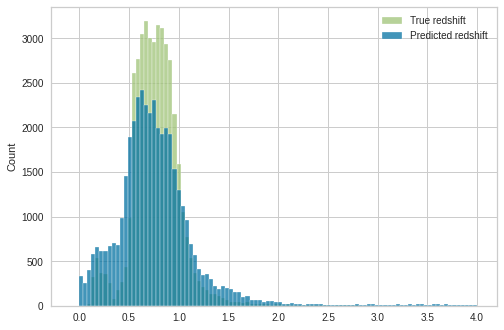

MSE: 0.16027498585357103


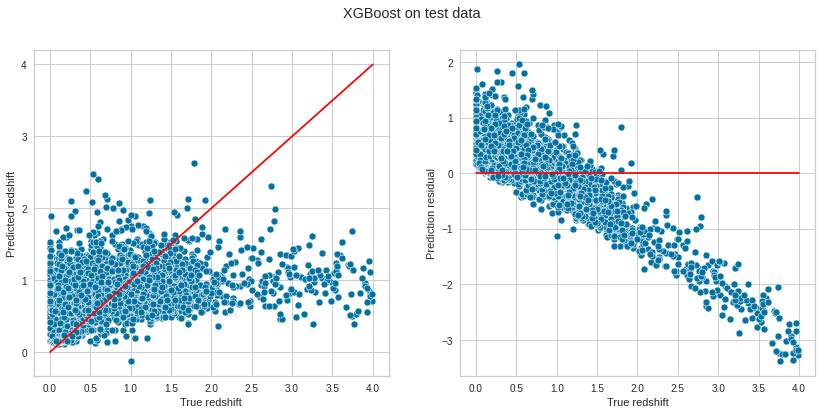

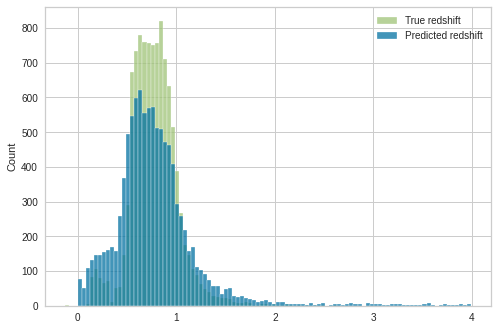


Prediction Error Plot


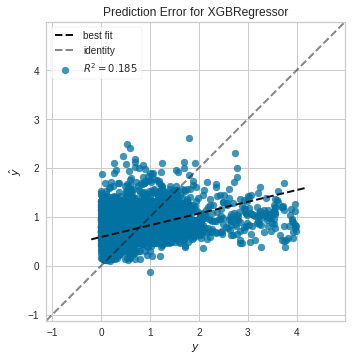

PredictionError(ax=<AxesSubplot:title={'center':'Prediction Error for XGBRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>,
                estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                       colsample_bylevel=1, colsample_bynode=1,
                                       colsample_bytree=1, gamma=0, gpu_id=-1,
                                       importance_type='gain',
                                       interaction_constraints='',
                                       learning_rate=0.300000012,
                                       max_delta_step=0, max_depth=6,
                                       min_child_weight=1, missing=nan,
                                       monotone_constraints='()',
                                       n_estimators=100, n_jobs=32,
                                       num_parallel_tree=1, random_state=0,
                                       reg_alpha=0, reg_lambda=1,
                                

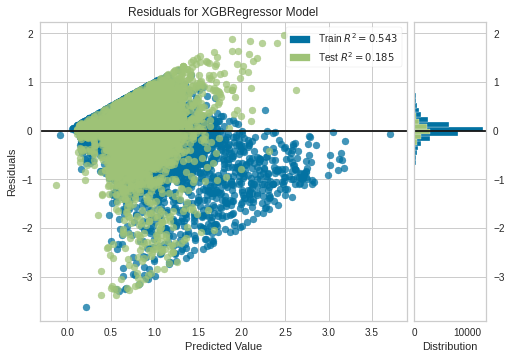

AttributeError: 'XGBRegressor' object has no attribute 'line_color'

,object_id_1,ra,dec,coord,skymap_id,g_cmodel_mag,r_cmodel_mag,i_cmodel_mag,z_cmodel_mag,y_cmodel_mag,...,i_cmodel_magsigma,z_cmodel_magsigma,y_cmodel_magsigma,object_id_2,specz_redshift_err,specz_redshift,specz_mag_i,specz_name,specz_ra,specz_dec
0,3.640710e+16,29.056840,-6.577962,"'(179117.015625, 99518.6015625, -23628.67578125)'",82780005,22.837498,21.159600,19.852673,19.388730,19.089922,...,0.004001,0.006953,0.007002,3.640710e+16,0.00030,0.69359,19.652,SDSS-DR12-1237679340566217300,29.056771,-6.577981
1,3.641160e+16,30.350384,-6.107037,"'(176986.390625, 103631.3828125, -21943.728515...",82790107,22.242287,21.505087,20.884990,20.588097,20.394600,...,0.002920,0.004457,0.007763,3.641160e+16,0.00033,0.68736,20.907,SDSS-DR12-1237679341103677901,30.350340,-6.107040
2,3.641140e+16,30.558539,-6.526887,"'(176465.515625, 104189.1328125, -23446.0078125)'",82790005,22.436127,21.514544,21.500206,20.762743,20.606396,...,0.004906,0.004987,0.009204,3.641140e+16,0.00073,3.35212,20.885,SDSS-DR12-1237679340566872600,30.558516,-6.526930
3,3.641160e+16,30.383171,-6.169957,"'(176906.15625, 103720.390625, -22168.94140625)'",82790107,22.804676,22.235598,21.882067,21.826208,21.726620,...,0.006623,0.010950,0.024310,3.641160e+16,0.03137,0.92066,21.729,SDSS-DR12-1237679439886287299,30.383171,-6.169992
4,3.641170e+16,30.200514,-6.105444,"'(177257.375, 103168.3828125, -21938.025390625)'",82790207,22.178066,21.270580,20.574970,20.477303,19.997612,...,0.001957,0.003098,0.004146,3.641170e+16,0.00146,4.03498,20.028,SDSS-DR12-1237679341103612342,30.200520,-6.105411


KeyboardInterrupt: 

<Figure size 360x360 with 0 Axes>

KeyboardInterrupt: 

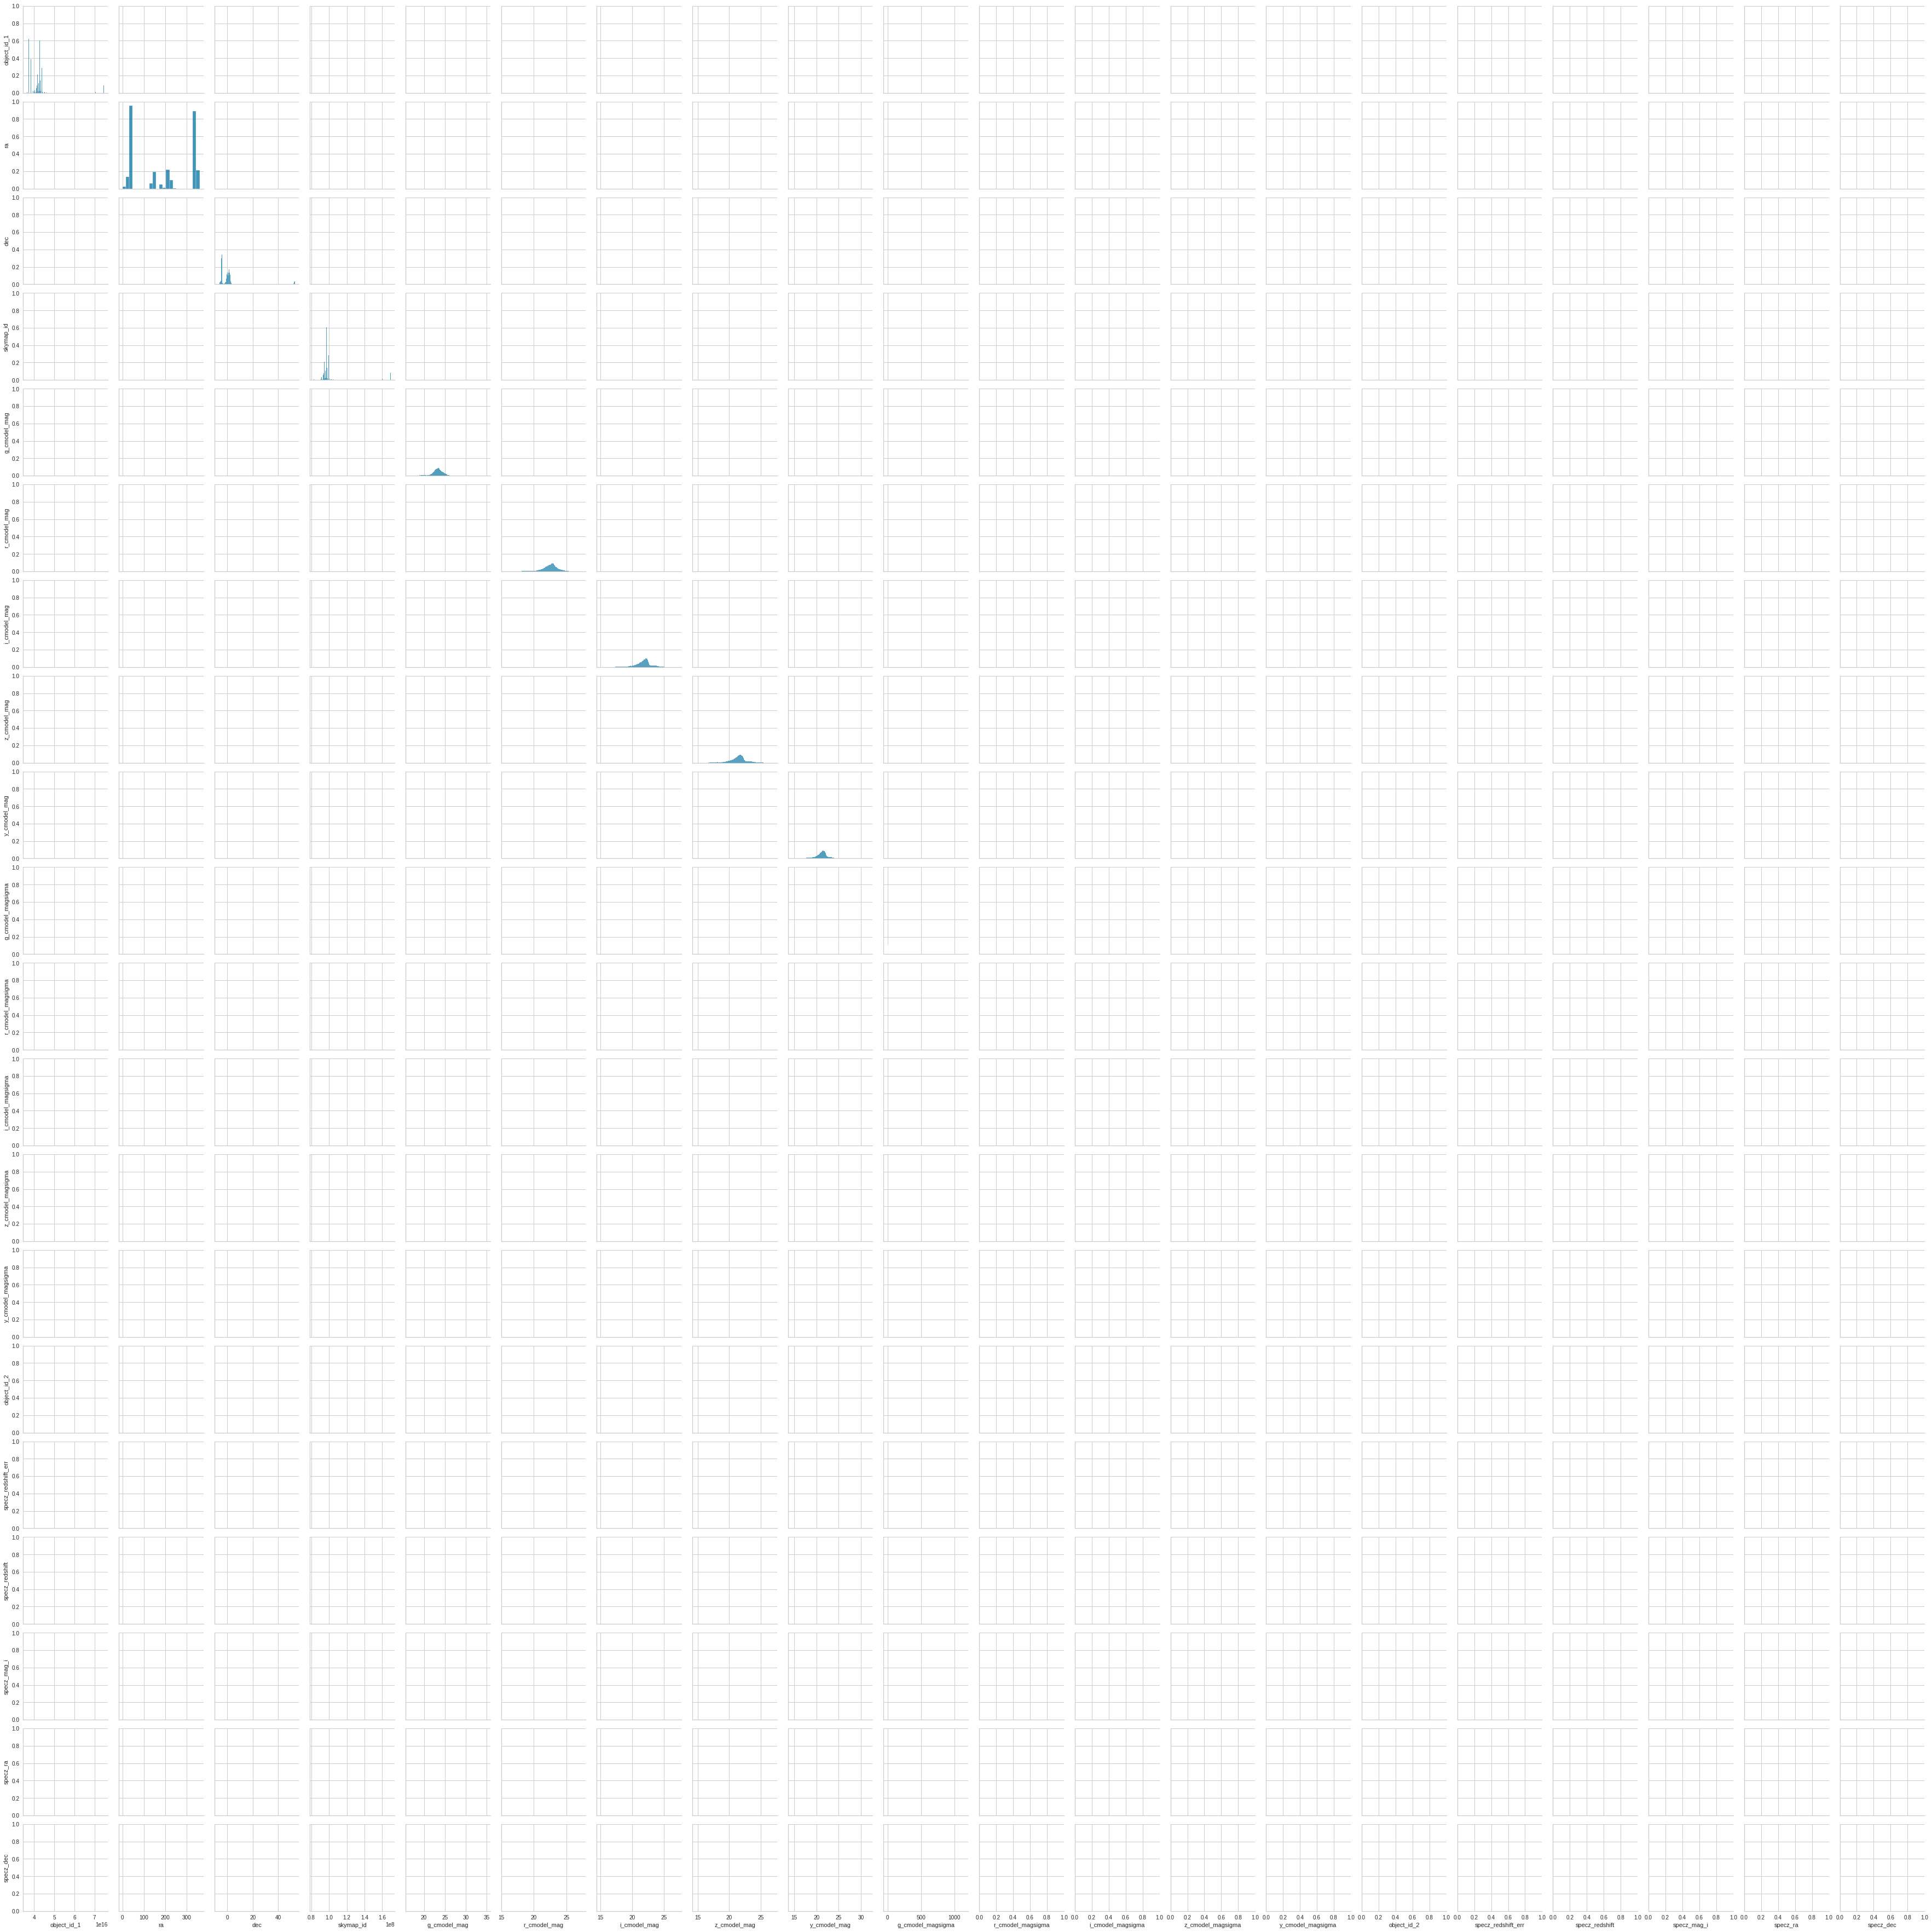

In [35]:
sns.pairplot(photozdata)

In [ ]:
#sns.relplot(x="clicks", y="sales",  ci="sd", hue='sale_amount_usd',palette="viridis",data=df)